In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'brk'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100


In [16]:
global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='brk_based_noseed_about'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6012942001794689 	 Validation loss: 0.4286604685298467 	 
  1%|          | 574/57400 [03:14<5:22:02,  2.94it/s]
Epoch 2 	 Training loss: 0.3937703029411595 	 Validation loss: 0.3553411374657841 	 
  2%|▏         | 1148/57400 [06:42<4:37:33,  3.38it/s]
Epoch 3 	 Training loss: 0.3526776110046001 	 Validation loss: 0.338196677676702 	 
  3%|▎         | 1722/57400 [10:10<5:11:33,  2.98it/s]
Epoch 4 	 Training loss: 0.3343707059318596 	 Validation loss: 0.32918222425347665 	 
  4%|▍         | 2296/57400 [13:39<5:15:47,  2.91it/s]
Epoch 5 	 Training loss: 0.32002607753779416 	 Validation loss: 0.321886177790367 	 
  5%|▌         | 2870/57400 [17:07<4:27:45,  3.39it/s]
Epoch 6 	 Training loss: 0.3095067785955472 	 Validation loss: 0.31660280515581873 	 
  6%|▌         | 3444/57400 [20:35<4:44:49,  3.16it/s]
Epoch 7 	 Training loss: 0.2997090492254766 	 Validation loss: 0.312849993170318 	 
  7%|▋         | 4018/57400 [23:29<4:38:51,  3.19it/s]
Epoch 8 	 Training lo

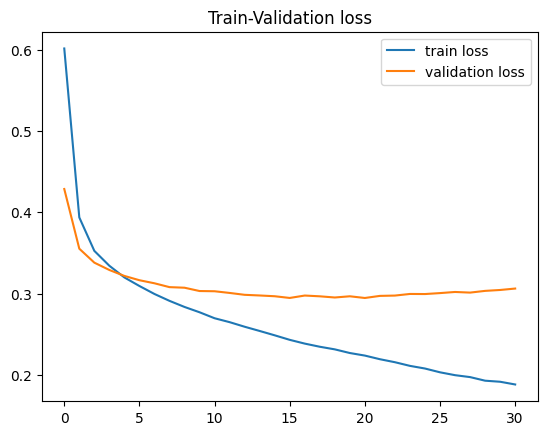

In [17]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [17]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('brk_based_noseed_about'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8367346938775511, 'precision': 0.8367346938775511, 'f1': 0.8367346938775511, 'accuracy': 0.8367346938775511}
MALE {'recall': 0.8411458333333334, 'precision': 0.8411458333333334, 'f1': 0.8411458333333333, 'accuracy': 0.8411458333333334}
FEMALE {'recall': 0.8325, 'precision': 0.8325, 'f1': 0.8325, 'accuracy': 0.8325} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6654040404040404, 'precision': 0.6654040404040404, 'f1': 0.6654040404040404, 'accuracy': 0.6654040404040404}
MALE {'recall': 0.6909975669099757, 'precision': 0.6909975669099757, 'f1': 0.6909975669099757, 'accuracy': 0.6909975669099757}
FEMALE {'recall': 0.6377952755905512, 'precision': 0.6377952755905512, 'f1': 0.6377952755905512, 'accuracy': 0.6377952755905512} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6831812255541069, 'precision': 0.6831812255541069, 'f1': 0.6831812255541069, 'accuracy': 0.6831812255541069}
MALE {'recall': 

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5825386954932262 	 Validation loss: 0.4310593301967039 	 
  1%|          | 574/57400 [03:02<3:28:58,  4.53it/s]
Epoch 2 	 Training loss: 0.4061065983896887 	 Validation loss: 0.36601406790442387 	 
  2%|▏         | 1148/57400 [05:18<4:00:36,  3.90it/s]
Epoch 3 	 Training loss: 0.36188184607527396 	 Validation loss: 0.34506840953382395 	 
  3%|▎         | 1722/57400 [07:34<2:50:11,  5.45it/s]
Epoch 4 	 Training loss: 0.34090669196137985 	 Validation loss: 0.3347662619109881 	 
  4%|▍         | 2296/57400 [09:46<3:40:33,  4.16it/s]
Epoch 5 	 Training loss: 0.32653241983585657 	 Validation loss: 0.3262783907732721 	 
  5%|▌         | 2870/57400 [11:58<3:31:24,  4.30it/s]
Epoch 6 	 Training loss: 0.31554771349716687 	 Validation loss: 0.3213114455594855 	 
  6%|▌         | 3444/57400 [14:13<3:10:47,  4.71it/s]
Epoch 7 	 Training loss: 0.30714351585206257 	 Validation loss: 0.318046323828778 	 
  7%|▋         | 4018/57400 [16:30<3:39:44,  4.05it/s]
Epoch 8 	 Train

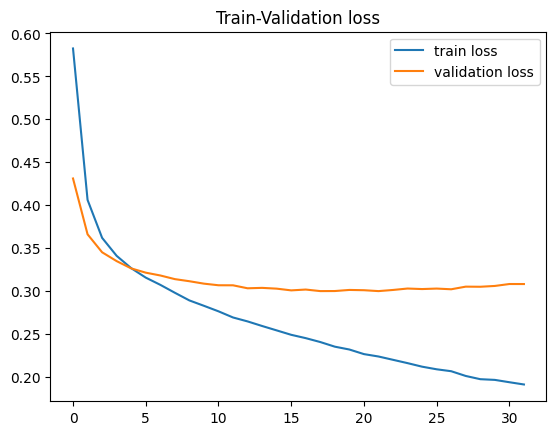

In [20]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='brk_based_noseed_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('brk_based_noseed_about2'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8367346938775511, 'precision': 0.8367346938775511, 'f1': 0.8367346938775511, 'accuracy': 0.8367346938775511}
MALE {'recall': 0.8541666666666666, 'precision': 0.8541666666666666, 'f1': 0.8541666666666666, 'accuracy': 0.8541666666666666}
FEMALE {'recall': 0.82, 'precision': 0.82, 'f1': 0.82, 'accuracy': 0.82} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6616161616161617, 'precision': 0.6616161616161617, 'f1': 0.6616161616161617, 'accuracy': 0.6616161616161617}
MALE {'recall': 0.6934306569343066, 'precision': 0.6934306569343066, 'f1': 0.6934306569343066, 'accuracy': 0.6934306569343066}
FEMALE {'recall': 0.6272965879265092, 'precision': 0.6272965879265092, 'f1': 0.6272965879265092, 'accuracy': 0.6272965879265092} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6779661016949152, 'precision': 0.6779661016949152, 'f1': 0.6779661016949152, 'accuracy': 0.6779661016949152}
MALE {'recall': 0.669191

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5667934754168946 	 Validation loss: 0.41156192603757824 	 
  1%|          | 574/57400 [03:09<4:27:09,  3.55it/s]
Epoch 2 	 Training loss: 0.38276305602610317 	 Validation loss: 0.35340134168075304 	 
  2%|▏         | 1148/57400 [06:31<5:10:12,  3.02it/s]
Epoch 3 	 Training loss: 0.34719519226289375 	 Validation loss: 0.3389285110821158 	 
  3%|▎         | 1722/57400 [09:25<4:17:13,  3.61it/s]
Epoch 4 	 Training loss: 0.32984451015028804 	 Validation loss: 0.3314832082744372 	 
  4%|▍         | 2296/57400 [12:15<4:34:27,  3.35it/s]
Epoch 5 	 Training loss: 0.3161541079966033 	 Validation loss: 0.32119562009633595 	 
  5%|▌         | 2870/57400 [15:37<5:17:44,  2.86it/s]
Epoch 6 	 Training loss: 0.30625212735103813 	 Validation loss: 0.3170703033269462 	 
  6%|▌         | 3444/57400 [18:59<4:19:26,  3.47it/s]
Epoch 7 	 Training loss: 0.29590826183038305 	 Validation loss: 0.31471375944250723 	 
  7%|▋         | 4018/57400 [22:22<5:05:51,  2.91it/s]
Epoch 8 	 Tr

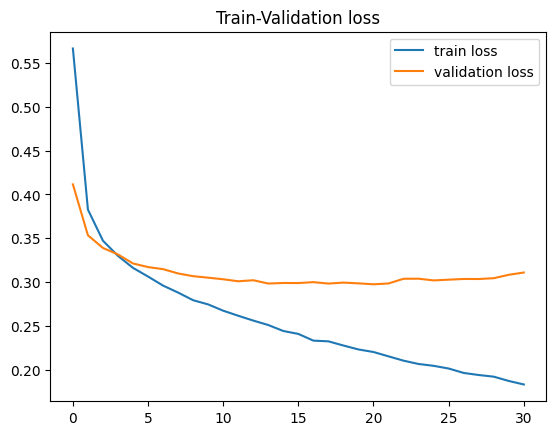

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='brk_based_noseed_about3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('brk_based_noseed_about3'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8418367346938775, 'precision': 0.8418367346938775, 'f1': 0.8418367346938774, 'accuracy': 0.8418367346938775}
MALE {'recall': 0.8489583333333334, 'precision': 0.8489583333333334, 'f1': 0.8489583333333334, 'accuracy': 0.8489583333333334}
FEMALE {'recall': 0.835, 'precision': 0.835, 'f1': 0.835, 'accuracy': 0.835} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6666666666666666, 'precision': 0.6666666666666666, 'f1': 0.6666666666666666, 'accuracy': 0.6666666666666666}
MALE {'recall': 0.6861313868613139, 'precision': 0.6861313868613139, 'f1': 0.6861313868613139, 'accuracy': 0.6861313868613139}
FEMALE {'recall': 0.6456692913385826, 'precision': 0.6456692913385826, 'f1': 0.6456692913385826, 'accuracy': 0.6456692913385826} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6727509778357236, 'precision': 0.6727509778357236, 'f1': 0.6727509778357236, 'accuracy': 0.6727509778357236}
MALE {'recall': 0.66

Resultados finales

In [20]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.8384353741496599, 'precision': 0.8384353741496599, 'f1': 0.8384353741496599, 'accuracy': 0.8384353741496599}
Métricas etiqueta male: {'recall': 0.8480902777777778, 'precision': 0.8480902777777778, 'f1': 0.8480902777777778, 'accuracy': 0.8480902777777778}
Métricas etiqueta female:  {'recall': 0.8291666666666666, 'precision': 0.8291666666666666, 'f1': 0.8291666666666666, 'accuracy': 0.8291666666666666}

 to
Resultado global: {'recall': 0.6645622895622896, 'precision': 0.6645622895622896, 'f1': 0.6645622895622896, 'accuracy': 0.6645622895622896}
Métricas etiqueta male: {'recall': 0.6901865369018654, 'precision': 0.6901865369018654, 'f1': 0.6901865369018654, 'accuracy': 0.6901865369018654}
Métricas etiqueta female:  {'recall': 0.636920384951881, 'precision': 0.636920384951881, 'f1': 0.636920384951881, 'accuracy': 0.636920384951881}

 as
Resultado global: {'recall': 0.6779661016949152, 'precision': 0.6779661016949152, 'f1': 0.67796

# TO

In [21]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6945962868501085 	 Validation loss: 0.6923785846112138 	 
  1%|          | 574/57400 [03:01<4:30:07,  3.51it/s]
Epoch 2 	 Training loss: 0.6939562632854808 	 Validation loss: 0.6934555445687246 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [06:04<4:00:55,  3.89it/s]
Epoch 3 	 Training loss: 0.6934713094076629 	 Validation loss: 0.6922574982804767 	 
  3%|▎         | 1722/57400 [09:09<4:02:32,  3.83it/s]
Epoch 4 	 Training loss: 0.6930608378677834 	 Validation loss: 0.6930737909624132 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [12:02<2:44:19,  5.59it/s]
Epoch 5 	 Training loss: 0.693076383776781 	 Validation loss: 0.6939589845932136 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [14:14<3:16:52,  4.62it/s]
Epoch 6 	 Training loss: 0.6932337730603766 	 Validation loss: 0.6928954144655648 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [16:42<4:17:27,  3.49it/s]
Epoch 7 	 Training loss: 0.6928271843373568 	 

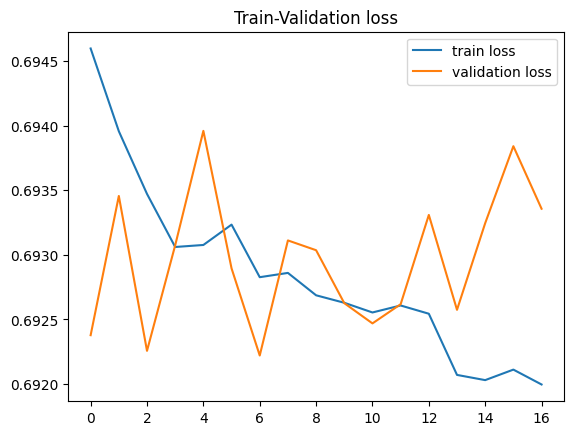

In [53]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='brk_based_noseed_to'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('brk_based_noseed_to'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5242346938775511, 'precision': 0.5242346938775511, 'f1': 0.5242346938775511, 'accuracy': 0.5242346938775511}
MALE {'recall': 0.15625, 'precision': 0.15625, 'f1': 0.15625, 'accuracy': 0.15625}
FEMALE {'recall': 0.8775, 'precision': 0.8775, 'f1': 0.8775, 'accuracy': 0.8775} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.49747474747474746, 'precision': 0.49747474747474746, 'f1': 0.49747474747474746, 'accuracy': 0.49747474747474746}
MALE {'recall': 0.15571776155717762, 'precision': 0.15571776155717762, 'f1': 0.15571776155717762, 'accuracy': 0.15571776155717762}
FEMALE {'recall': 0.8661417322834646, 'precision': 0.8661417322834646, 'f1': 0.8661417322834646, 'accuracy': 0.8661417322834646} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5084745762711864, 'precision': 0.5084745762711864, 'f1': 0.5084745762711864, 'accuracy': 0.5084745762711864}
MALE {'recall': 0.16414141414141414, 'precision': 0.

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6958835562139438 	 Validation loss: 0.6924398430323196 	 
  1%|          | 574/57400 [02:55<4:47:35,  3.29it/s]
Epoch 2 	 Training loss: 0.6951494805696534 	 Validation loss: 0.6923651392177 	 
  2%|▏         | 1148/57400 [05:45<4:33:59,  3.42it/s]
Epoch 3 	 Training loss: 0.6943409182261091 	 Validation loss: 0.6923178990008467 	 
  3%|▎         | 1722/57400 [08:38<4:31:12,  3.42it/s]
Epoch 4 	 Training loss: 0.6944661300356795 	 Validation loss: 0.6930577805486776 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [11:43<3:42:05,  4.14it/s]
Epoch 5 	 Training loss: 0.6942808866916218 	 Validation loss: 0.6926925950131174 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [14:30<4:16:41,  3.54it/s]
Epoch 6 	 Training loss: 0.6942279322222135 	 Validation loss: 0.6932019055899927 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [17:16<4:10:57,  3.58it/s]
Epoch 7 	 Training loss: 0.6940637941144485 	 Validation loss: 0.692631774029

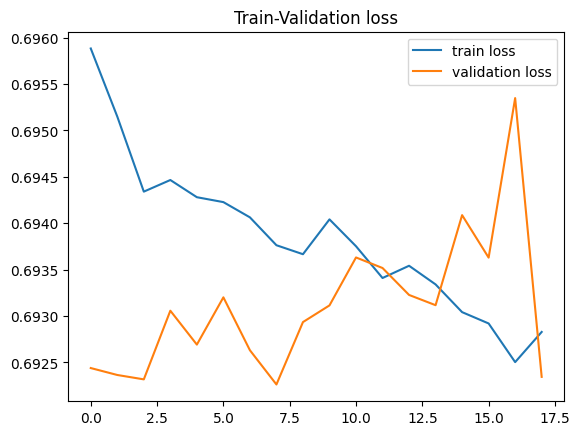

In [55]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='brk_based_noseed_to2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [23]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('brk_based_noseed_to2'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.49489795918367346, 'precision': 0.49489795918367346, 'f1': 0.49489795918367346, 'accuracy': 0.49489795918367346}
MALE {'recall': 0.296875, 'precision': 0.296875, 'f1': 0.296875, 'accuracy': 0.296875}
FEMALE {'recall': 0.685, 'precision': 0.685, 'f1': 0.685, 'accuracy': 0.685} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5315656565656566, 'precision': 0.5315656565656566, 'f1': 0.5315656565656566, 'accuracy': 0.5315656565656566}
MALE {'recall': 0.38686131386861317, 'precision': 0.38686131386861317, 'f1': 0.38686131386861317, 'accuracy': 0.38686131386861317}
FEMALE {'recall': 0.6876640419947506, 'precision': 0.6876640419947506, 'f1': 0.6876640419947506, 'accuracy': 0.6876640419947506} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4954367666232073, 'precision': 0.4954367666232073, 'f1': 0.4954367666232073, 'accuracy': 0.4954367666232073}
MALE {'recall': 0.30808080808080807, 'precision': 0.

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6952738121203844 	 Validation loss: 0.6945785395169662 	 
  1%|          | 574/57400 [03:23<5:13:51,  3.02it/s]
Epoch 2 	 Training loss: 0.694916837618326 	 Validation loss: 0.6955052806159198 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [06:08<4:26:39,  3.52it/s]
Epoch 3 	 Training loss: 0.694527834238491 	 Validation loss: 0.6944174453363581 	 
  3%|▎         | 1722/57400 [08:54<4:16:51,  3.61it/s]
Epoch 4 	 Training loss: 0.6941399125687336 	 Validation loss: 0.6935328386597714 	 
  4%|▍         | 2296/57400 [11:42<4:37:20,  3.31it/s]
Epoch 5 	 Training loss: 0.6942772942137635 	 Validation loss: 0.69343618013091 	 
  5%|▌         | 2870/57400 [14:53<3:24:22,  4.45it/s]
Epoch 6 	 Training loss: 0.6938836806119527 	 Validation loss: 0.6937323737952669 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [17:39<4:05:52,  3.66it/s]
Epoch 7 	 Training loss: 0.6940343955252644 	 Validation loss: 0.6943240276837753 	 

2 epoch without impro

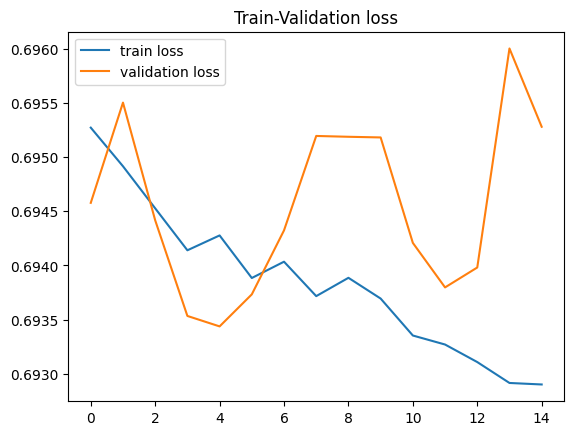

In [57]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='brk_based_noseed_to3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [24]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('brk_based_noseed_to3'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5829081632653061, 'precision': 0.5829081632653061, 'f1': 0.5829081632653061, 'accuracy': 0.5829081632653061}
MALE {'recall': 0.4375, 'precision': 0.4375, 'f1': 0.4375, 'accuracy': 0.4375}
FEMALE {'recall': 0.7225, 'precision': 0.7225, 'f1': 0.7225, 'accuracy': 0.7225} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5467171717171717, 'precision': 0.5467171717171717, 'f1': 0.5467171717171717, 'accuracy': 0.5467171717171717}
MALE {'recall': 0.45985401459854014, 'precision': 0.45985401459854014, 'f1': 0.45985401459854014, 'accuracy': 0.45985401459854014}
FEMALE {'recall': 0.6404199475065617, 'precision': 0.6404199475065617, 'f1': 0.6404199475065617, 'accuracy': 0.6404199475065617} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5449804432855281, 'precision': 0.5449804432855281, 'f1': 0.5449804432855281, 'accuracy': 0.5449804432855281}
MALE {'recall': 0.37626262626262624, 'precision': 0.37626262

Resultados finales

In [28]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5340136054421769, 'precision': 0.5340136054421769, 'f1': 0.5340136054421769, 'accuracy': 0.5340136054421769}
Métricas etiqueta male: {'recall': 0.296875, 'precision': 0.296875, 'f1': 0.296875, 'accuracy': 0.296875}
Métricas etiqueta female:  {'recall': 0.7616666666666667, 'precision': 0.7616666666666667, 'f1': 0.7616666666666667, 'accuracy': 0.7616666666666667}

 to
Resultado global: {'recall': 0.5252525252525253, 'precision': 0.5252525252525253, 'f1': 0.5252525252525253, 'accuracy': 0.5252525252525253}
Métricas etiqueta male: {'recall': 0.33414436334144365, 'precision': 0.33414436334144365, 'f1': 0.33414436334144365, 'accuracy': 0.33414436334144365}
Métricas etiqueta female:  {'recall': 0.731408573928259, 'precision': 0.731408573928259, 'f1': 0.731408573928259, 'accuracy': 0.731408573928259}

 as
Resultado global: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059

# AS

In [29]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6946448547707202 	 Validation loss: 0.6933290402768022 	 
  1%|          | 574/57400 [03:43<5:47:55,  2.72it/s]
Epoch 2 	 Training loss: 0.6941263669459247 	 Validation loss: 0.6919700169967393 	 
  2%|▏         | 1148/57400 [07:03<4:33:37,  3.43it/s]
Epoch 3 	 Training loss: 0.6932516751181373 	 Validation loss: 0.6924561241925773 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [09:54<4:42:42,  3.28it/s]
Epoch 4 	 Training loss: 0.6916414504474879 	 Validation loss: 0.6918202911393118 	 
  4%|▍         | 2296/57400 [13:17<5:40:36,  2.70it/s]
Epoch 5 	 Training loss: 0.6895323675060937 	 Validation loss: 0.6906743241568744 	 
  5%|▌         | 2870/57400 [16:46<5:22:17,  2.82it/s]
Epoch 6 	 Training loss: 0.6877508575700302 	 Validation loss: 0.6910769848500268 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [19:49<4:42:21,  3.18it/s]
Epoch 7 	 Training loss: 0.6865640031336077 	 Validation loss: 0.6906355659840471 	 
  7%|▋         | 4

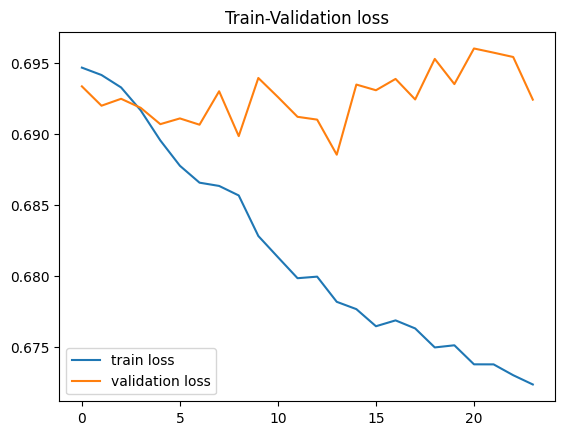

In [61]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='brk_based_noseed_as1'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [30]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('brk_based_noseed_as1'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6760204081632653, 'precision': 0.6760204081632653, 'f1': 0.6760204081632653, 'accuracy': 0.6760204081632653}
MALE {'recall': 0.640625, 'precision': 0.640625, 'f1': 0.640625, 'accuracy': 0.640625}
FEMALE {'recall': 0.71, 'precision': 0.71, 'f1': 0.7100000000000001, 'accuracy': 0.71} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6919191919191919, 'precision': 0.6919191919191919, 'f1': 0.6919191919191919, 'accuracy': 0.6919191919191919}
MALE {'recall': 0.708029197080292, 'precision': 0.708029197080292, 'f1': 0.708029197080292, 'accuracy': 0.708029197080292}
FEMALE {'recall': 0.6745406824146981, 'precision': 0.6745406824146981, 'f1': 0.6745406824146981, 'accuracy': 0.6745406824146981} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.7196870925684485, 'precision': 0.7196870925684485, 'f1': 0.7196870925684485, 'accuracy': 0.7196870925684485}
MALE {'recall': 0.6439393939393939, 'precision': 0.643

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6936712571345139 	 Validation loss: 0.6925361782817517 	 
  1%|          | 574/57400 [02:50<4:46:14,  3.31it/s]
Epoch 2 	 Training loss: 0.6923882263462718 	 Validation loss: 0.6923578674510374 	 
  2%|▏         | 1148/57400 [05:37<4:30:28,  3.47it/s]
Epoch 3 	 Training loss: 0.6911158321834192 	 Validation loss: 0.69005252143084 	 
  3%|▎         | 1722/57400 [08:23<4:18:22,  3.59it/s]
Epoch 4 	 Training loss: 0.6902308929257277 	 Validation loss: 0.6906831102856135 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [11:11<5:02:08,  3.04it/s]
Epoch 5 	 Training loss: 0.6886519045156885 	 Validation loss: 0.690824997627129 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [14:34<4:32:07,  3.34it/s]
Epoch 6 	 Training loss: 0.6873196028043169 	 Validation loss: 0.6901880654238038 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [17:21<4:10:11,  3.59it/s]
Epoch 7 	 Training loss: 0.6863307574900185 	 Validation loss: 0.690129393238

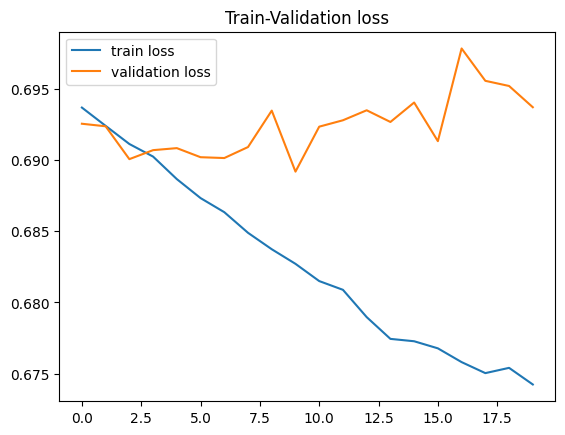

In [63]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='brk_based_noseed_as2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [31]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('brk_based_noseed_as2'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6556122448979592, 'precision': 0.6556122448979592, 'f1': 0.6556122448979592, 'accuracy': 0.6556122448979592}
MALE {'recall': 0.5598958333333334, 'precision': 0.5598958333333334, 'f1': 0.5598958333333334, 'accuracy': 0.5598958333333334}
FEMALE {'recall': 0.7475, 'precision': 0.7475, 'f1': 0.7475, 'accuracy': 0.7475} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6691919191919192, 'precision': 0.6691919191919192, 'f1': 0.6691919191919192, 'accuracy': 0.6691919191919192}
MALE {'recall': 0.6082725060827251, 'precision': 0.6082725060827251, 'f1': 0.6082725060827251, 'accuracy': 0.6082725060827251}
FEMALE {'recall': 0.7349081364829396, 'precision': 0.7349081364829396, 'f1': 0.7349081364829396, 'accuracy': 0.7349081364829396} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6870925684485006, 'precision': 0.6870925684485006, 'f1': 0.6870925684485006, 'accuracy': 0.6870925684485006}
MALE {'recall': 

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6948447446582209 	 Validation loss: 0.6936127371707205 	 
  1%|          | 574/57400 [02:46<3:27:21,  4.57it/s]
Epoch 2 	 Training loss: 0.6928824359739284 	 Validation loss: 0.6930517059261516 	 
  2%|▏         | 1148/57400 [05:39<5:16:44,  2.96it/s]
Epoch 3 	 Training loss: 0.6914564085546686 	 Validation loss: 0.691685625052048 	 
  3%|▎         | 1722/57400 [08:29<4:29:05,  3.45it/s]
Epoch 4 	 Training loss: 0.6904967615205652 	 Validation loss: 0.6916310756893481 	 
  4%|▍         | 2296/57400 [11:15<4:16:19,  3.58it/s]
Epoch 5 	 Training loss: 0.6888193117409218 	 Validation loss: 0.6897031967922792 	 
  5%|▌         | 2870/57400 [14:02<4:25:49,  3.42it/s]
Epoch 6 	 Training loss: 0.6883150044218589 	 Validation loss: 0.6933676600456238 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [17:07<5:12:14,  2.88it/s]
Epoch 7 	 Training loss: 0.6867301746527907 	 Validation loss: 0.6922113703469098 	 

2 epoch without improvement
  7%|▋         | 40

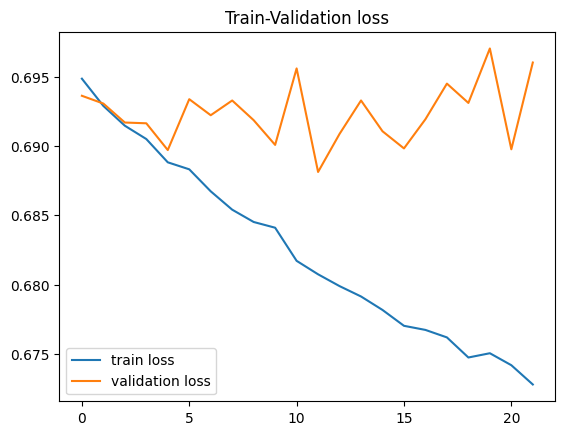

In [65]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='brk_based_noseed_as3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [32]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('brk_based_noseed_as3'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6645408163265306, 'precision': 0.6645408163265306, 'f1': 0.6645408163265306, 'accuracy': 0.6645408163265306}
MALE {'recall': 0.6953125, 'precision': 0.6953125, 'f1': 0.6953125, 'accuracy': 0.6953125}
FEMALE {'recall': 0.635, 'precision': 0.635, 'f1': 0.635, 'accuracy': 0.635} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6742424242424242, 'precision': 0.6742424242424242, 'f1': 0.6742424242424242, 'accuracy': 0.6742424242424242}
MALE {'recall': 0.7250608272506083, 'precision': 0.7250608272506083, 'f1': 0.7250608272506082, 'accuracy': 0.7250608272506083}
FEMALE {'recall': 0.6194225721784777, 'precision': 0.6194225721784777, 'f1': 0.6194225721784777, 'accuracy': 0.6194225721784777} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.7105606258148631, 'precision': 0.7105606258148631, 'f1': 0.710560625814863, 'accuracy': 0.7105606258148631}
MALE {'recall': 0.6818181818181818, 'precision': 0.681818

Resultados finales

In [33]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.6653911564625851, 'precision': 0.6653911564625851, 'f1': 0.6653911564625851, 'accuracy': 0.6653911564625851}
Métricas etiqueta male: {'recall': 0.6319444444444444, 'precision': 0.6319444444444444, 'f1': 0.6319444444444444, 'accuracy': 0.6319444444444444}
Métricas etiqueta female:  {'recall': 0.6975, 'precision': 0.6975, 'f1': 0.6975, 'accuracy': 0.6975}

 to
Resultado global: {'recall': 0.6784511784511784, 'precision': 0.6784511784511784, 'f1': 0.6784511784511784, 'accuracy': 0.6784511784511784}
Métricas etiqueta male: {'recall': 0.6804541768045418, 'precision': 0.6804541768045418, 'f1': 0.6804541768045418, 'accuracy': 0.6804541768045418}
Métricas etiqueta female:  {'recall': 0.6762904636920385, 'precision': 0.6762904636920385, 'f1': 0.6762904636920385, 'accuracy': 0.6762904636920385}

 as
Resultado global: {'recall': 0.7057800956106041, 'precision': 0.7057800956106041, 'f1': 0.7057800956106041, 'accuracy': 0.7057800956106041}